In [35]:
#@title Import data from GitHub (mlp_class) { display-mode: "form" }
#@markdown Install GpyTorch.

#@markdown Files from GitHub:
#@markdown - **qm_coord.npy** (2100, 14, 3)
#@markdown - **qm_elem.txt** ([8, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1])
#@markdown - PM3
#@markdown  - **energy_sqm.npy** (2100,)
#@markdown  - **qm_grad_sqm.npy** (2100, 14, 3)

#@markdown - B3LYP/6-31+G*
#@markdown  - **energy.npy**  (2100,)
#@markdown  - **qm_grad.npy** (2100, 14, 3)

%%capture
!rm *py*
!rm qm_elem.txt
!rm -r sample_data
!wget https://github.com/cc-ats/mlp_class/raw/main/Claisen_Rearrangement/energy.npy
!wget https://github.com/cc-ats/mlp_class/raw/main/Claisen_Rearrangement/energy_sqm.npy
!wget https://github.com/cc-ats/mlp_class/raw/main/Claisen_Rearrangement/qm_grad.npy
!wget https://github.com/cc-ats/mlp_class/raw/main/Claisen_Rearrangement/qm_grad_sqm.npy
!wget https://github.com/cc-ats/mlp_class/raw/main/Claisen_Rearrangement/qm_coord.npy
!wget https://github.com/cc-ats/mlp_class/raw/main/Claisen_Rearrangement/qm_elem.txt

!pip install pytorch-lightning > /dev/null
!pip install gpytorch > /dev/null

In [36]:
#@title Import libraries 

#@markdown - math, typing (Sequence, Tuple)

#@markdown - Torch (nn, nn.functional, Tensor. TensorDataset, DataLoader, random_split)

#@markdown - gpytorch

import math
from typing import Sequence, Tuple, Optional

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
import gpytorch

from torch.utils.data import TensorDataset, DataLoader, random_split

In [37]:
import numpy as np

qm_coord = torch.from_numpy(np.array(np.load("qm_coord.npy"), dtype="float32")) #.cuda()
atom_types = np.loadtxt("qm_elem.txt", dtype=int)
elems = np.unique(atom_types).tolist()
atom_types = torch.from_numpy(np.array([elems.index(i) for i in atom_types])) #.cuda()
atom_types = atom_types.repeat(len(qm_coord), 1)

energy = torch.from_numpy(np.array((np.load("energy.npy") - np.load("energy_sqm.npy")) * 27.2114 * 23.061, dtype="float32")) #.cuda()
energy = energy - energy.mean()
qm_gradient = torch.from_numpy(np.array((np.load("qm_grad.npy") - np.load("qm_grad_sqm.npy")) * 27.2114 * 23.061 / 0.529177249, dtype="float32")) #.cuda()

In [38]:
atom_types = np.loadtxt("qm_elem.txt", dtype=int)
elems = np.unique(atom_types).tolist()
atom_types = torch.from_numpy(np.array([elems.index(i) for i in atom_types])) #.cuda()
atom_types = atom_types.repeat(len(qm_coord), 1)

In [39]:
def pairwise_vector(coords: Tensor) -> Tensor:
    num_batches, num_channels, _ = coords.size()
    rij = coords[:, :, None] - coords[:, None]
    mask = ~torch.eye(num_channels, dtype=torch.bool, device=coords.device) # remove self-interaction
    rij = torch.masked_select(rij, mask.unsqueeze(2)).view(num_batches, num_channels, num_channels - 1, 3)
    return rij

def symmetry_function_g2(rij: Tensor, Rcr: float, EtaR: Tensor, ShfR: Tensor) -> Tensor:
    dij = torch.norm(rij, dim=3)
    fij = (torch.cos(dij / Rcr * math.pi) + 1) * 0.5
    g2 = torch.sum(torch.exp(-EtaR.unsqueeze(dim=2) * (dij.unsqueeze(dim=-1) - ShfR.unsqueeze(dim=2))**2) * fij.unsqueeze(dim=-1), dim=2)
    #g2 = torch.sum(torch.exp(-EtaR.unsqueeze(dim=1) * (dij.unsqueeze(dim=-1) - ShfR.unsqueeze(dim=1))**2) * fij.unsqueeze(dim=-1), dim=2)
    return g2

def symmetry_function_g3(rij: Tensor, Rca: float, Zeta: Tensor, EtaA: Tensor) -> Tensor:
    c = torch.combinations(torch.arange(rij.size(2)), r=2)
    print(c)
    rij = rij[:, :, c]
    r12 = rij[:, :, :, 0]
    r13 = rij[:, :, :, 1]
    r23 = r12 - r13
    d12 = torch.norm(r12, dim=3)
    d13 = torch.norm(r13, dim=3)
    d23 = torch.norm(r23, dim=3)
    f12 = (torch.cos(d12 / Rca * math.pi) + 1) * 0.5
    f13 = (torch.cos(d13 / Rca * math.pi) + 1) * 0.5
    f23 = (torch.cos(d23 / Rca * math.pi) + 1) * 0.5
    cosine = torch.einsum('ijkl,ijkl->ijk', r12, r13) / (d12 * d13)

    g3 = torch.sum(2**(1 - Zeta.unsqueeze(dim=2)) * (1 + cosine.unsqueeze(dim=-1))**Zeta.unsqueeze(dim=2) * torch.exp(-EtaA.unsqueeze(dim=2) * (d12**2 + d13**2 + d23**2).unsqueeze(dim=-1)) * (f12 * f13 * f23).unsqueeze(dim=-1), dim=2)
    return g3

def symmetry_function_g3ani(rij: Tensor, Rca: float, Zeta: Tensor, ShfZ: Tensor, EtaA: Tensor, ShfA: Tensor) -> Tensor:
    c = torch.combinations(torch.arange(rij.size(2)), r=2)
    rij = rij[:, :, c]
    r12 = rij[:, :, :, 0]
    r13 = rij[:, :, :, 1]

    r23 = r12 - r13
    d12 = torch.norm(r12, dim=3)
    d13 = torch.norm(r13, dim=3)
    f12 = (torch.cos(d12 / Rca * math.pi) + 1) * 0.5
    f13 = (torch.cos(d13 / Rca * math.pi) + 1) * 0.5
    cosine = torch.einsum('ijkl,ijkl->ijk', r12, r13) / (d12 * d13)
    cosine = torch.cos(torch.acos(cosine).unsqueeze(dim=-1) - ShfA.unsqueeze(dim=2))
    #cosine = torch.cos(torch.acos(cosine).unsqueeze(dim=-1) - ShfA.unsqueeze(dim=1))
    g3 = torch.sum(2**(1 - Zeta.unsqueeze(dim=2)) * (1 + cosine)**Zeta.unsqueeze(dim=2) * torch.exp(-EtaA.unsqueeze(dim=2) * (0.5 * (d12 + d13).unsqueeze(dim=-1) - ShfZ.unsqueeze(dim=2))**2) * (f12 * f13).unsqueeze(dim=-1), dim=2)
    #g3 = torch.sum(2**(1 - Zeta.unsqueeze(dim=1)) * (1 + cosine)**Zeta.unsqueeze(dim=1) * torch.exp(-EtaA.unsqueeze(dim=1) * (0.5 * (d12 + d13).unsqueeze(dim=-1) - ShfZ.unsqueeze(dim=1))**2) * (f12 * f13).unsqueeze(dim=-1), dim=2)
    return g3

In [40]:
class Feature(nn.Module):
    def __init__(self, Rcr: float, EtaR: Tensor, ShfR: Tensor, Rca: float, Zeta: Tensor, EtaA: Tensor) -> None:
        super().__init__()
        assert len(EtaR) == len(ShfR)
        assert len(Zeta) == len(EtaA)
        self.Rcr = Rcr
        self.Rca = Rca
        self.EtaR = torch.Tensor(EtaR)
        self.ShfR = torch.Tensor(ShfR)
        self.Zeta = torch.Tensor(Zeta)
        self.EtaA = torch.Tensor(EtaA)

    def forward(self, coords: Tensor, atom_types: Tensor) -> Tensor:
        num_batches, num_channels, _ = coords.size()
        rij = pairwise_vector(coords)
        EtaR = self.EtaR[atom_types].to(device=coords.device)
        ShfR = self.ShfR[atom_types].to(device=coords.device)
        Zeta = self.Zeta[atom_types].to(device=coords.device)
        EtaA = self.EtaA[atom_types].to(device=coords.device)
        g2 = symmetry_function_g2(rij, self.Rcr, EtaR, ShfR)
        g3 = symmetry_function_g3(rij, self.Rca, Zeta, EtaA)

        return torch.concat((g2, g3), dim=2)

    @property
    def output_length(self) -> int:
        return len(self.EtaR[0]) + len(self.EtaA[0])


In [41]:
class FeatureANI(nn.Module):
    def __init__(self, Rcr: float, EtaR: Tensor, ShfR: Tensor, Rca: float, Zeta: Tensor, ShfZ: Tensor, EtaA: Tensor, ShfA: Tensor) -> None:
        super().__init__()
        assert len(EtaR) == len(ShfR)
        assert len(Zeta) == len(ShfZ) == len(EtaA) == len(ShfA)
        self.Rcr = Rcr
        self.Rca = Rca
        self.EtaR = torch.Tensor(EtaR)
        self.ShfR = torch.Tensor(ShfR)
        self.Zeta = torch.Tensor(Zeta)
        self.ShfZ = torch.Tensor(ShfZ)
        self.EtaA = torch.Tensor(EtaA)
        self.ShfA = torch.Tensor(ShfA)

    def forward(self, coords: Tensor, atom_types: Tensor) -> Tensor:
        num_batches, num_channels, _ = coords.size()
        rij = pairwise_vector(coords)
        EtaR = self.EtaR[atom_types].to(device=coords.device)
        ShfR = self.ShfR[atom_types].to(device=coords.device)
        Zeta = self.Zeta[atom_types].to(device=coords.device)
        ShfZ = self.ShfZ[atom_types].to(device=coords.device)
        EtaA = self.EtaA[atom_types].to(device=coords.device)
        ShfA = self.ShfA[atom_types].to(device=coords.device)
        g2 = symmetry_function_g2(rij, self.Rcr, EtaR, ShfR)
        g3 = symmetry_function_g3ani(rij, self.Rca, Zeta, ShfZ, EtaA, ShfA)

        return torch.concat((g2, g3), dim=2)

    @property
    def output_length(self) -> int:
        return len(self.EtaR[0]) + len(self.EtaA[0])

The Gaussian Approximation Potential (GAP) formalism is motivated by considering an observable, such as molecular energy (E), as a linear combination of unobservables, such as atomic energies (ε): 
\begin{equation}
E = \sum_{i}^{\textrm{Atoms}}ε(\textbf{r}_{ij})
\end{equation}
where $\textbf{r}_{ij}$ is the relative position between atoms i and j.

To use Gaussian processes to determine the underlying function of atomic energies when only the linear combination of functions are avalible, as observations, an NxM matrix $\textbf{L}$ describes the relationship between N unobserved atomic energies and M observed energies:
\begin{equation}
\textbf{y}=\textbf{L}\textbf{y}'
\end{equation}
The covariance of the observations can then be given by:
\begin{equation}
\textbf{K}_{MM}=\textbf{L}^{\textrm{T}}\textbf{K}_{NN}\textbf{L}
\end{equation}


In [42]:
class SOAP_kern(gpytorch.kernels.PolynomialKernel):
    def __init__(self, natms):
        super().__init__(power=2.0)
        self.noise = torch.nn.parameter.Parameter(torch.ones((1)))
        self.natms = natms
    def K(self,
        x1: torch.Tensor,
        x2: torch.Tensor=None,
        diag: Optional[bool]=False,
        last_dim_is_batch: Optional[bool]=False,
        **params,
        ) -> torch.Tensor:
        if x2 is None:
            x2 = torch.clone(x1)
        kern = super().forward(x1,x2,diag=False,last_dim_is_batch=False)+self.noise*torch.eye(int(x1.size()[0]),dtype=torch.float)
        L = torch.zeros(int(x1.size()[0]), int(x1.size()[0]/self.natms), dtype=torch.float)
        j, k = 0, 0
        for i in range(int(x1.size()[0])):
            L[i,k] = 1.
            j += 1
            if j == self.natms:
                j = 0
                k += 1
        LT = L.T
        return torch.matmul(torch.matmul(LT,kern), L)
    def Ks(self,
        x1: torch.Tensor,
        x2: torch.Tensor,
        diag: Optional[bool]=False,
        last_dim_is_batch: Optional[bool]=False,
        **params,
        ) -> torch.Tensor:
        kern = super().forward(x1,x2,diag=False,last_dim_is_batch=False)
        L = torch.zeros(int(x2.size()[0]), int(x2.size()[0]/self.natms), dtype=torch.float)
        j, k = 0, 0
        for i in range(int(x2.size()[0])):
            L[i,k] = 1.
            j += 1
            if j == self.natms:
                j = 0
                k += 1
        LT = L.T
        return torch.matmul(kern, L)
    def forward(self, x1, x2=None):
        if x2 == None:
          x2 = torch.clone(x1)
        x1_eq_x2 = torch.equal(x1, x2)
        if x1_eq_x2:
            res = self.K(x1)
        else:
            res = self.Ks(x1, x2)
        return res

In [43]:
class BP_GAP_GPR(gpytorch.models.ExactGP):
    def __init__(self,train_x, train_y, likelihood, natm):
        super(BP_GAP_GPR, self).__init__(train_x, train_y, likelihood)
        self.natm = natm
        self.mean_module = gpytorch.means.ZeroMean() #ConstantMean()
        self.covar_module = SOAP_kern(natm)
    def forward(self,x):
        mean_x_ = self.mean_module(x)
        covar_x = self.covar_module.K(x)
        mean_x = torch.zeros(covar_x.size()[0])
        j,k = 0,self.natm
        for i in range(int(covar_x.size()[0])):
            mean_x[i] = torch.sum(mean_x_[j:k])
            j += self.natm
            k += self.natm
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


In [44]:
ani = True

if ani:
  # From TorchANI
  Rcr = 5.2000e+00
  Rca = 3.5000e+00
  EtaR = [1.6000000e+01]
  ShfR = [9.0000000e-01,1.1687500e+00,1.4375000e+00,1.7062500e+00,1.9750000e+00,2.2437500e+00,2.5125000e+00,2.7812500e+00,3.0500000e+00,3.3187500e+00,3.5875000e+00,3.8562500e+00,4.1250000e+00,4.3937500e+00,4.6625000e+00,4.9312500e+00]
  Zeta = [3.2000000e+01]
  ShfZ = [1.9634954e-01,5.8904862e-01,9.8174770e-01,1.3744468e+00,1.7671459e+00,2.1598449e+00,2.5525440e+00,2.9452431e+00]
  EtaA = [8.0000000e+00]
  ShfA = [9.0000000e-01,1.5500000e+00,2.2000000e+00,2.8500000e+00]
  EtaR, ShfR = np.array(np.meshgrid(EtaR, ShfR)).reshape(2, -1)
  Zeta, ShfZ, EtaA, ShfA = np.array(np.meshgrid(Zeta, ShfZ, EtaA, ShfA)).reshape(4, -1)
  EtaR = np.repeat([EtaR], 3, axis=0)
  ShfR = np.repeat([ShfR], 3, axis=0)
  Zeta = np.repeat([Zeta], 3, axis=0)
  ShfZ = np.repeat([ShfZ], 3, axis=0)
  EtaA = np.repeat([EtaA], 3, axis=0)
  ShfA = np.repeat([ShfA], 3, axis=0)
  descriptor = FeatureANI(Rcr, EtaR, ShfR, Rca, Zeta, ShfZ, EtaA, ShfA)
else:
  Rcr = 6.0
  Rca = 6.0
  ShfR = [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]] # H, C, O
  EtaR = [[0.0, 0.04, 0.14, 0.32, 0.71, 1.79], [0.0, 0.04, 0.14, 0.32, 0.71, 1.79], [0.0, 0.04, 0.14, 0.32, 0.71, 1.79]] # H, C, O
  Zeta = [[1, 2, 4, 8, 16, 32], [1, 2, 4, 8, 16, 32], [1, 2, 4, 8, 16, 32]] # H, C, O
  EtaA = [[0.0, 0.04, 0.14, 0.32, 0.71, 1.79], [0.0, 0.04, 0.14, 0.32, 0.71, 1.79], [0.0, 0.04, 0.14, 0.32, 0.71, 1.79]] # H, C, O
  descriptor = Feature(Rcr, EtaR, ShfR, Rca, Zeta, EtaA)


In [45]:
nskip = 5

# Prepare training data 
X = descriptor.forward(qm_coord, atom_types)[::nskip,:,:]
shape = X.shape
X  = X.reshape(shape[0]*shape[1],shape[2])
X = torch.nn.functional.normalize(X) # Preprocess Inputs
Y = energy[::nskip]

# Initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = BP_GAP_GPR(X, Y, likelihood, 14)


In [46]:
training_iter = 50 

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(X)
    # Calc loss and backprop gradients
    loss = -mll(output, Y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (
        i + 1, training_iter, loss.item(),
    ))
    optimizer.step()

# Print Trained hyperparameters
for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')



Iter 1/50 - Loss: 2.559
Iter 2/50 - Loss: 2.531
Iter 3/50 - Loss: 2.502
Iter 4/50 - Loss: 2.473
Iter 5/50 - Loss: 2.445
Iter 6/50 - Loss: 2.419
Iter 7/50 - Loss: 2.400
Iter 8/50 - Loss: 2.398
Iter 9/50 - Loss: 2.421
Iter 10/50 - Loss: 2.430
Iter 11/50 - Loss: 2.415
Iter 12/50 - Loss: 2.399
Iter 13/50 - Loss: 2.392
Iter 14/50 - Loss: 2.391
Iter 15/50 - Loss: 2.394
Iter 16/50 - Loss: 2.397
Iter 17/50 - Loss: 2.400
Iter 18/50 - Loss: 2.401
Iter 19/50 - Loss: 2.401
Iter 20/50 - Loss: 2.399
Iter 21/50 - Loss: 2.396
Iter 22/50 - Loss: 2.393
Iter 23/50 - Loss: 2.390
Iter 24/50 - Loss: 2.387
Iter 25/50 - Loss: 2.385
Iter 26/50 - Loss: 2.385
Iter 27/50 - Loss: 2.387
Iter 28/50 - Loss: 2.389
Iter 29/50 - Loss: 2.389
Iter 30/50 - Loss: 2.388
Iter 31/50 - Loss: 2.386
Iter 32/50 - Loss: 2.384
Iter 33/50 - Loss: 2.383
Iter 34/50 - Loss: 2.383
Iter 35/50 - Loss: 2.384
Iter 36/50 - Loss: 2.385
Iter 37/50 - Loss: 2.385
Iter 38/50 - Loss: 2.385
Iter 39/50 - Loss: 2.384
Iter 40/50 - Loss: 2.384
Iter 41/5

In [47]:
model.eval()
likelihood.eval()

# Break predictions into sections to limit memory usage 
nsections = 5
for i in range(nsections):
  nstart = int(len(qm_coord)/nsections * (i))
  nend = int(len(qm_coord)/nsections * (i+1)) 
  qm_coord_test = torch.autograd.Variable(qm_coord[nstart:nend,:,:], requires_grad=True)
  X_test = descriptor.forward(qm_coord_test, atom_types[nstart:nend,:])
  shape = X_test.shape
  X_test = X_test.reshape(shape[0]*shape[1],shape[2])
  X_test = torch.nn.functional.normalize(X_test)
  y_preds = model(X_test) #likelihood(model(X_test))
  mean_y_test = y_preds.mean
  auto_grad_test, = torch.autograd.grad(mean_y_test.sum(), [qm_coord_test])
  if i == 0:
    pred_test = mean_y_test.detach()
    grad_test = auto_grad_test.detach()
  else:
    pred_test = torch.concat((pred_test, mean_y_test.detach()))
    grad_test = torch.concat((grad_test, auto_grad_test.detach()))

def eval(ref, pred):
    rmse = torch.sqrt(torch.mean((ref-pred)**2))
    q2 = 1 - torch.sum((ref-pred)**2)/torch.sum((ref-torch.mean(ref))**2)
    return rmse, q2

y_rmse, y_q2 = eval(energy ,pred_test)
print("Energy RMSE: ",y_rmse, "Q^2: ", y_q2)
f_rmse, f_q2 = eval(grad_test, qm_gradient)
print("Force RMSE: ",f_rmse, "Q^2: ", f_q2)




Energy RMSE:  tensor(2.2788) Q^2:  tensor(0.6278)
Force RMSE:  tensor(7.6583) Q^2:  tensor(-1.0244)


In [48]:
print(energy.shape, pred_test.shape)

torch.Size([2100]) torch.Size([2100])


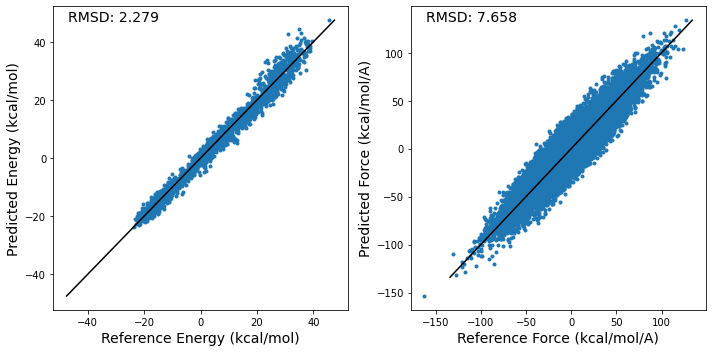

In [49]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2,figsize=(10,5))

e1 = energy.cpu().detach().numpy() + np.load("energy_sqm.npy") * 27.2114 * 23.061
e2 = pred_test.cpu().detach().numpy() + np.load("energy_sqm.npy") * 27.2114 * 23.061
ax[0].plot(e1, e2, linestyle='none', marker='.', )
ax[0].plot([np.max(np.concatenate((e1,e2))), -np.max(np.concatenate((e1,e2)))], [np.max(np.concatenate((e1,e2))), -np.max(np.concatenate((e1,e2)))], color="k", linewidth=1.5)
ax[0].set_xlabel("Reference Energy (kcal/mol)", size=14)
ax[0].set_ylabel("Predicted Energy (kcal/mol)", size=14)
ax[0].annotate('RMSD: %.3f' % np.sqrt(np.mean((e1 - e2)**2)), xy=(0.05, 0.95), xycoords='axes fraction', size=14)

f1 = -qm_gradient.cpu().detach().numpy().reshape(-1) - np.load("qm_grad_sqm.npy").reshape(-1) * 27.2114 * 23.061 / 0.529177249
f2 = -grad_test.cpu().detach().numpy().reshape(-1) - np.load("qm_grad_sqm.npy").reshape(-1) * 27.2114 * 23.061 / 0.529177249

ax[1].plot(f1, f2, linestyle='none', marker='.', )
plt.plot([-np.abs(np.max(np.concatenate((f1,f2)))), np.max(np.concatenate((f1,f2)))], [-np.max(np.concatenate((f1,f2))), np.max(np.concatenate((f1,f2)))], color="k", linewidth=1.5)
ax[1].set_xlabel("Reference Force (kcal/mol/A)", size=14)
ax[1].set_ylabel("Predicted Force (kcal/mol/A)", size=14)
ax[1].annotate('RMSD: %.3f' % np.sqrt(np.mean((f1 - f2)**2)), xy=(0.05, 0.95), xycoords='axes fraction', size=14)

plt.tight_layout()
plt.savefig('rmsd.png', dpi=300)

In [50]:
# Evaluate Training Set 
y_preds = model(X) #likelihood(model(X_test))
mean_y = y_preds.mean
y_rmse, y_q2 = eval(Y ,mean_y)

print(y_rmse, y_q2)

/usr/local/lib/python3.7/dist-packages/gpytorch/models/exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


tensor(2.1751, grad_fn=<SqrtBackward0>) tensor(0.6254, grad_fn=<RsubBackward1>)


In [51]:
# Check manual calculation
print(mean_y)
test = torch.matmul(torch.matmul(model.covar_module.Ks(X, X), torch.linalg.inv(model.covar_module.K(X) + model.likelihood.noise*torch.eye(420))), Y.reshape((Y.shape[0],1)))
test_y = torch.zeros(int(2100/nksip))
j,k = 0,14
for i in range(int(2100/nskip)):
    test_y[i] = torch.sum(test.flatten()[j:k])
    j += 14
    k += 14
print(test_y)
y_rmse, y_q2 = eval(Y ,test_y.flatten())
print(y_rmse, y_q2)

tensor([-1.0088, -0.3525,  2.4512, -0.2988,  0.8789,  1.0293,  0.8486, -0.1289,
         1.8066, -1.1396, -0.8477,  0.4609, -2.6621, -1.7822, -1.4375, -1.0449,
        -2.1738, -0.8906, -2.1475,  1.1299, -1.5518,  0.7676,  1.6260,  0.9355,
        -0.2910,  1.1924, -2.5234, -0.9785, -2.2725,  3.7461,  0.0605, -2.5674,
        -1.8682, -1.4727, -0.3369,  2.5508,  0.6270, -1.2188, -0.6670, -2.7598,
        -1.8555, -1.5068,  1.7529,  0.5898,  1.1699, -1.2422,  0.9922, -1.8311,
        -2.8984, -2.0586, -1.0156, -2.5947, -1.0176,  1.5889,  0.6523,  1.5625,
        -0.0566,  0.5225, -1.1895, -1.4531, -0.4570,  0.0273, -2.2266,  1.9453,
        -1.6006, -0.6016, -1.1357, -0.5029, -1.4785,  0.1514, -0.3018,  0.0312,
         0.2148, -0.2314, -1.6084, -0.2461,  1.7998, -1.8926,  0.7568,  0.0293,
         0.2246,  3.0596,  0.9229,  2.5273, -0.3311, -0.2002,  1.4561, -1.6250,
         2.0068, -0.6602,  0.9609,  0.0596,  1.4805,  0.0967, -1.4727,  1.4570,
         0.3730, -0.0322,  0.6631,  1.02

NameError: ignored